# PREDICTION OF EPITOPES USING ALPHAFOLD2 STRUCTURES AND GRAPH NEURAL NETWORKS
>#### Magnus H. Høie (s216559), Frederik S. Gade (s184260), Ida Meitil (s153020)
> Epitopes are surface-exposed regions of a pathogenic molecule or antigen, which are targeted
by the adaptive immune system by e.g. B-cell receptors. Binding is largely determined by the
surface features of the target molecule. AlphaFold2 is a deep-learning protein folding model
achieving near experimental quality prediction for many proteins. Furthermore, graph-based
neural networks such as ProteinSolver allow structural representation of proteins suitable for
tasks such as epitope prediction. We investigate improved epitope prediction using Alphafold2
modelled structures over sequence-only models.
>
>*02456 DEEP LEARNING, DTU COMPUTE, FALL 2021*


Running this notebook requires specific versions of PyTorch and associated packages to be compatible with ProteinSolver. The following commands should suffice: 

```
conda env create -f PS_gpu.yaml
conda activate PS_gpu
conda install nb_conda 
```

*Note that installing* `nb_conda` *makes it possible to use the conda environment in jupyter*

### Setup

In [1]:
import sys
import glob
import os
import os.path

import math
import torch
from torch import nn, Tensor, sigmoid, tanh, relu, softmax
from torch.utils import data
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics import matthews_corrcoef as mcc
import copy
import numpy as np

import kmbio
from kmbio import PDB
from Bio import SeqIO
import torch_geometric

import ProteinSolver as proteinsolver

In [2]:
INPUT_DIR = "data/cleaned_pdbs/"
STATE_FILE = "ProteinSolver/e53-s1952148-d93703104.state"

In [3]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

EARLY_STOPPING = True

SOLVED = False
print("Using {} structures for FFNN, RNN and Discotope".format("solved" if SOLVED else "AF2"))

device = "cuda" if torch.cuda.is_available() else "cpu"
print("The device in use is", device)

Using AF2 structures for FFNN, RNN and Discotope
The device in use is cuda


In [4]:
if SOLVED:
    SEQ_KEY_NAME = "seq_pdb"
    embedding_type = "data/solved_embeddings/"
else:
    SEQ_KEY_NAME = "seq"
    embedding_type = "data/af2_embeddings/"

In [5]:
class EpitopeDataset(data.Dataset):
    def __init__(self,embeddings,labels,mask,batch=4):
        self.embeddings = embeddings
        self.labels = labels
        self.mask = mask

    def __len__(self):
        return (self.embeddings).shape[0]

    def __getitem__(self,idx):
        return self.embeddings[idx] , self.labels[idx], self.mask[idx]

def create_sequential_datasets(list_of_dicts):
    n_seqs = len(list_of_dicts)
    seq_max_length = max([len(embed_dict[SEQ_KEY_NAME]) for embed_dict in list_of_dicts])
    embedding_dim = 128

    with open("data/postapr2018_antigens.test.txt", "r") as infile:
        test_names = set([l.strip() for l in infile.readlines()])
    with open("data/preapr2018_antigens.train.txt", "r") as infile:
        train_names = set([l.strip() for l in infile.readlines()])
    with open("data/preapr2018_antigens.validation.txt", "r") as infile:
        val_names = set([l.strip() for l in infile.readlines()])

    X = torch.zeros(size=(n_seqs, seq_max_length, embedding_dim))
    y = torch.zeros(size=(n_seqs, seq_max_length))
    mask = torch.zeros(size=(n_seqs, seq_max_length))
    test_idx = list()
    train_idx = list()
    val_idx = list()
    for i, embed_dict in enumerate(list_of_dicts):
        seq = embed_dict[SEQ_KEY_NAME]
        pdb_id = embed_dict['pdb_id']
        embedding = embed_dict['per_tok'].detach()
        
        if pdb_id in test_names:
            test_idx.append(i)
        elif pdb_id in train_names:
            train_idx.append(i)
        elif pdb_id in val_names:
            val_idx.append(i)
        y_ = torch.Tensor([1 if letter.isupper() else 0 for letter in seq])

        X[i, 0:embedding.shape[0]] = embedding
        y[i, 0:len(y_)] = y_
        mask[i, 0:len(y_)] = torch.ones((1,len(y_)))

    test_idx = np.asarray(test_idx)
    train_idx = np.asarray(train_idx)
    val_idx = np.asarray(val_idx)


    random_indices = np.random.choice(len(train_idx), len(train_idx), replace=False)

    inputs_train = X[train_idx, :, :]
    inputs_test = X[test_idx, :, :]
    inputs_val = X[val_idx, :, :]
    targets_train = y[train_idx]
    targets_test = y[test_idx]
    targets_val = y[val_idx]
    masks_train = mask[train_idx]
    masks_test = mask[test_idx]
    masks_val = mask[val_idx]

    print("Training dims:", inputs_train.shape, targets_train.shape)
    print("Test dims:", inputs_test.shape, targets_test.shape)
    print("Validation dims:", inputs_val.shape, targets_val.shape)
    
    training_set = EpitopeDataset(inputs_train.to(device), targets_train.to(device), masks_train.to(device))
    validation_set = EpitopeDataset(inputs_val.to(device), targets_val.to(device), masks_val.to(device))
    test_set = EpitopeDataset(inputs_test.to(device), targets_test.to(device), masks_test.to(device))

    return training_set, validation_set, test_set

def create_positional_datasets(list_of_dicts):
    with open("data/postapr2018_antigens.test.txt", "r") as infile:
        test_names = set([l.strip() for l in infile.readlines()])
    with open("data/preapr2018_antigens.train.txt", "r") as infile:
        train_names = set([l.strip() for l in infile.readlines()])
    with open("data/preapr2018_antigens.validation.txt", "r") as infile:
        val_names = set([l.strip() for l in infile.readlines()])

    test_idx = []
    train_idx = []
    val_idx = []

    # Define partition sizes
    y = torch.Tensor()
    X = torch.Tensor()
    for embed_dict in list_of_dicts:
        seq = embed_dict[SEQ_KEY_NAME]
        y_ = torch.Tensor([1 if letter.isupper() else 0 for letter in seq])
        #print(seq, y)

        pdb_id = embed_dict['pdb_id']

        if pdb_id in test_names:
            test_idx.extend(list(range(len(y), len(y)+len(y_))))
        elif pdb_id in train_names:
            train_idx.extend(list(range(len(y), len(y)+len(y_))))
        elif pdb_id in val_names:
            val_idx.extend(list(range(len(y), len(y)+len(y_))))


        embedding = embed_dict['per_tok'].detach()
        X = torch.cat((X, embedding), 0)
        y = torch.cat((y, y_), 0)
    
    inputs_train = X[train_idx, :]
    inputs_val = X[val_idx, :]
    inputs_test = X[test_idx, :]
    targets_train = y[train_idx]
    targets_val = y[val_idx]
    targets_test = y[test_idx]

    # Get inputs and targets for each partition

    print("Training dims:", inputs_train.shape, targets_train.shape)
    print("Test dims:", inputs_test.shape, targets_test.shape)
    print("Validation dims:", inputs_val.shape, targets_val.shape)

    training_set = data.TensorDataset(inputs_train.to(device), targets_train.to(device))
    validation_set = data.TensorDataset(inputs_val.to(device), targets_val.to(device))
    test_set = data.TensorDataset(inputs_test.to(device), targets_test.to(device))

    return training_set, validation_set, test_set

In [6]:
embedding_dicts = list()

for pt in glob.glob(embedding_type+'*.pt'):
    pt_obj = torch.load(pt)
    embedding_dicts.append(pt_obj)

fasta = {}
with open("data/antigens_before_clustering.fasta", "r") as file_one:
    for line in file_one:
        line = line.strip()
        if not line:
            continue
        if line.startswith(">"):
            active_sequence_name = line[1:]
            if active_sequence_name not in fasta:
                fasta[active_sequence_name] = []
            continue
        sequence = line
        fasta[active_sequence_name].append(sequence)

for embed_dict in embedding_dicts:
    assert len(embed_dict[SEQ_KEY_NAME]) == len(fasta[embed_dict['pdb_id']][0])
    embed_dict[SEQ_KEY_NAME] = fasta[embed_dict['pdb_id']][0]

# Models

Since we are working with amino acid residue data, there are three general approaches:
1. Working with the data for individual residues. This doesn't preserve the structural information within the data structure, but due to the fact that ProteinSolver incorporates the structural context into each embedding, a lot of the signal should still be there.
2. Working with the data sequentially, preserving some of the biological context along the sequence - although it does not capture all. This is sequences and RNNs.  
3. Working with with data structurally, preserving the biological context in which the amino acid residues are observed. This is PDB files and GNN representations.


## Individual residue model (FFNN)
This is the simplest possible model, as it acts on each position individually. The architecture uses a batch-norm, three increasingly smaller linear layers with ReLU activation and a small amount of dropout. For this model, the RNN, and the GNN, early stopping is implemented using the validation loss.

In [7]:
training_set, val_set, test_set = create_positional_datasets(embedding_dicts)

Training dims: torch.Size([49181, 128]) torch.Size([49181])
Test dims: torch.Size([26680, 128]) torch.Size([26680])
Validation dims: torch.Size([4244, 128]) torch.Size([4244])


In [8]:
BATCH_SIZE = 64
MAX_EPOCHS = 200
LR = 1e-3
LR_DECAY = 1e-5

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layers = nn.Sequential(
                    nn.BatchNorm1d(128),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Dropout(p=0.1),
                    nn.Linear(64, 16),
                    nn.ReLU(),
                    nn.Dropout(p=0.1),
                    nn.Linear(16, 1, bias=False),
                    nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)
    
net = Net()
net.to(device)

print(net)

Net(
  (layers): Sequential(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=16, out_features=1, bias=False)
    (8): Sigmoid()
  )
)


In [10]:
trainloader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=False)

train_X, train_y = training_set.tensors
test_X, test_y = test_set.tensors
val_X, val_y = val_set.tensors

In [11]:
criterion = nn.BCELoss(reduction="none")
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=LR_DECAY)

def weight_reset(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        m.reset_parameters()

net.apply(weight_reset)
losses=[]
training_plot=[]
test_plot=[]
val_plot=[]
auc_train_plot=[]
auc_test_plot=[]
mcc_train_plot=[]
mcc_test_plot=[]

last_score=np.inf
max_es_rounds = 5
es_rounds = max_es_rounds
best_epoch = 0

for epoch in range(MAX_EPOCHS):  # loop over the dataset multiple times
    net.train()
   
    for i, data in enumerate(trainloader,0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        #scheduler.step()     
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(torch.flatten(outputs), labels.to(device))
        loss = torch.sum(loss)
        loss.backward()
        optimizer.step()
    
# print statistics
    with torch.no_grad():
        test_loss=0
        train_loss=0
        net.eval()
        inputs, labels = train_X, train_y

        outputs = net(inputs) 

        loss = criterion(torch.flatten(outputs), labels)
        loss = torch.mean(loss)
        training_plot.append(loss.cpu().numpy())
        auc_train_plot.append(roc_auc_score(labels.cpu(), outputs.cpu().flatten()))
        mcc_train_plot.append(mcc(labels.cpu(), outputs.cpu().flatten()>.1))
 

        inputs, labels = test_X, test_y
        outputs = net(inputs)
        loss = criterion(torch.flatten(outputs), labels)
        loss = torch.mean(loss)
        test_plot.append(loss.cpu().numpy())
        auc_test_plot.append(roc_auc_score(labels.cpu(), outputs.cpu().flatten()))
        fpr, tpr, _ = roc_curve(labels.cpu(), outputs.cpu().flatten())
        mcc_test_plot.append(mcc(labels.cpu(), outputs.cpu().flatten()>.1))

        inputs, labels = val_X, val_y
        outputs = net(inputs)
        valloss = criterion(torch.flatten(outputs), labels)
        valloss = torch.mean(valloss)
        val_plot.append(valloss.cpu().numpy())
        print("Epoch {}, training loss {}, test loss {}, validation loss {}".format(epoch, training_plot[-1], test_plot[-1], valloss))
        print("Epoch {}, training AUC {}, test AUC {}".format(epoch, auc_train_plot[-1], auc_test_plot[-1]))
        print("Epoch {}, training MCC {}, test MCC {}".format(epoch, mcc_train_plot[-1], mcc_test_plot[-1]))
        
    if EARLY_STOPPING:
        if last_score > valloss:
            last_score = valloss
            best_epoch = epoch
            es_rounds = max_es_rounds
            best_model = copy.deepcopy(net)
            ffnn_fpr, ffnn_tpr = fpr, tpr
        else:
            if es_rounds > 0:
                es_rounds -=1
            else:
                print('EARLY-STOPPING !')
                print('Best epoch found: nº {}'.format(best_epoch))
                print('Exiting. . .')
                break

print("Finished training.")

Epoch 0, training loss 0.2649185359477997, test loss 0.26786381006240845, validation loss 0.32478106021881104
Epoch 0, training AUC 0.6747612543698802, test AUC 0.6563184323793703
Epoch 0, training MCC 0.11547967264766935, test MCC 0.10224730599529396
Epoch 1, training loss 0.2627163231372833, test loss 0.2666051685810089, validation loss 0.32288941740989685
Epoch 1, training AUC 0.6851370000431881, test AUC 0.6632438312074426
Epoch 1, training MCC 0.12830684974790837, test MCC 0.10493040226547935
Epoch 2, training loss 0.26190996170043945, test loss 0.26675117015838623, validation loss 0.323234885931015
Epoch 2, training AUC 0.6886527446288107, test AUC 0.6614547204832986
Epoch 2, training MCC 0.13335274577638115, test MCC 0.1024690671040694
Epoch 3, training loss 0.2612265348434448, test loss 0.26635581254959106, validation loss 0.3223806619644165
Epoch 3, training AUC 0.6915946805656603, test AUC 0.6627947837234919
Epoch 3, training MCC 0.13417273286945547, test MCC 0.10216762413596

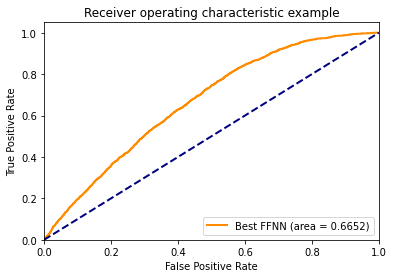

In [12]:
plt.figure()
lw = 2
plt.plot(
    ffnn_fpr,
    ffnn_tpr,
    color="darkorange",
    lw=lw,
    label="Best FFNN (area = %0.4f)" % auc(ffnn_fpr, ffnn_tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [13]:
#plt.figure(figsize=(16,12))
#plt.subplot(3, 1, 1)
#plt.title('Score per epoch')
#plt.ylabel('Binary Cross-entropy')
# plt.plot(list(range(len(losses))), [x[0] for x in losses], label=['Trains BCE loss'])
#plt.plot(list(range(len(training_plot))), test_plot, label=['Test BCE loss'])
#plt.plot(list(range(len(training_plot))), training_plot, label=['Train BCE loss'])
#plt.plot(list(range(len(training_plot))), val_plot, label=['Validation BCE loss'])

#plt.legend()
#plt.subplot(3, 1, 2)
#plt.ylabel('ROC-AUC Score')
# plt.plot(list(range(len(losses))), [x[2] for x in losses], label=['Trains ROC_AUC'])
#plt.plot(list(range(len(training_plot))), auc_test_plot, label=['Test ROC_AUC'])
#plt.plot(list(range(len(training_plot))), auc_train_plot, label=['Train ROC_AUC'])

#plt.subplot(3, 1, 3)
#plt.ylabel('MCC Score')
# plt.plot(list(range(len(losses))), [x[2] for x in losses], label=['Trains ROC_AUC'])
#plt.plot(list(range(len(training_plot))), mcc_test_plot, label=['Test MCC'])
#plt.plot(list(range(len(training_plot))), mcc_train_plot, label=['Train MCC'])

#plt.xlabel('Epoch')


#plt.legend()
#plt.legend()
#plt.show()

## Sequential model (RNN)
This is a slightly more advanced model, as it acts along each sequence. The architecture uses a bidirectional simple RNN plus a single linear layer with dropout.

In [14]:
BATCH_SIZE = 8
MAX_EPOCHS = 200
LR = 1e-4
LR_DECAY = 1e-5

In [15]:
training_set, val_set, test_set = create_sequential_datasets(embedding_dicts)

Training dims: torch.Size([216, 927, 128]) torch.Size([216, 927])
Test dims: torch.Size([117, 927, 128]) torch.Size([117, 927])
Validation dims: torch.Size([24, 927, 128]) torch.Size([24, 927])


In [16]:
class SimpleRNN(torch.nn.Module):
    def __init__(self, input_size):
        super(SimpleRNN, self).__init__()
        #self.bn_input = nn.BatchNorm1d(927)

        self.n_layers = 1
        self.hidden_dim = 32

        #self.rnn = nn.RNN(input_size, self.hidden_dim, self.n_layers, batch_first=True)
        self.rnn = nn.RNN(input_size, self.hidden_dim, self.n_layers, batch_first=True, bidirectional=True)
        
    
        self.dense = nn.Sequential(
                                    nn.Linear(in_features=2*self.hidden_dim, out_features=1)
#                                    nn.Linear(in_features=2*self.hidden_dim, out_features=self.hidden_dim),
#                                    nn.ReLU(),
#                                    nn.Linear(in_features=self.hidden_dim, out_features=int(self.hidden_dim/2)),
#                                    nn.ReLU(),
#                                    nn.Linear(in_features=int(self.hidden_dim/2), out_features=int(self.hidden_dim/4)), 
#                                    nn.ReLU(),
#                                    nn.Linear(in_features=int(self.hidden_dim/4), out_features=1),
                                    )
        # Dense out
        #self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Sigmoid()

    def forward(self, x):
        #x = self.bn_input(x)
    
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(4)

        # Convolutional modules
        x, hidden = self.rnn(x)
        #x = self.act(x)
        x = self.dropout(x)

        # Output MLP
        x = self.dense(x)

        # Output sigmoid
        out = self.out(x)

        return out, hidden

    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

net = SimpleRNN(128)
net.to(device)

print(net)

SimpleRNN(
  (rnn): RNN(128, 32, batch_first=True, bidirectional=True)
  (dense): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Sigmoid()
)


In [17]:
trainloader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE)

In [18]:
print("Starting training...")

train_X, train_y, train_mask = training_set[:]
test_X, test_y, test_mask = test_set[:]

criterion= nn.BCELoss(reduction='none')
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=LR_DECAY)

def weight_reset(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        m.reset_parameters()

net.apply(weight_reset)
losses=[]
training_plot=[]
test_plot=[]
auc_train_plot=[]
auc_test_plot=[]
mcc_train_plot=[]
mcc_test_plot=[]

last_score=np.inf
max_es_rounds = 5
es_rounds = max_es_rounds
best_epoch = 0

for epoch in range(MAX_EPOCHS):  # loop over the dataset multiple times
    net.train()
   
    for i, data in enumerate(trainloader,0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, mask = data
        inputs = inputs.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        #scheduler.step()     
        # forward + backward + optimize
        outputs, hidden = net(inputs)
        loss = criterion(torch.squeeze(outputs), labels)
        loss=loss*mask
        loss=torch.sum(loss)/torch.sum(mask)
   
        loss.backward()
        optimizer.step()
    
# print statistics
    with torch.no_grad():
        test_loss=0
        train_loss=0
        net.eval()
        inputs, labels, mask = training_set[:]

        outputs, hidden = net(inputs) 

        loss = criterion(torch.squeeze(outputs), labels)
        loss=loss*mask
        loss=torch.sum(loss)/torch.sum(mask)
        training_plot.append(loss.cpu().numpy())
        auc_train_plot.append(roc_auc_score(labels.cpu()[mask.cpu()>0], outputs.cpu().squeeze()[mask.cpu()>0]))
        mcc_train_plot.append(mcc(labels.cpu()[mask.cpu()>0], outputs.cpu().squeeze()[mask.cpu()>0]>.1))
 

        inputs, labels, mask = test_set[:]
        outputs, hidden = net(inputs)
        loss = criterion(torch.squeeze(outputs), labels)
        loss=loss*mask
        loss=torch.sum(loss)/torch.sum(mask)       
        test_plot.append(loss.cpu().numpy())
        fpr, tpr, _ = roc_curve(labels.cpu()[mask.cpu()>0], outputs.cpu()[mask.cpu()>0].squeeze())
        #labels, outputs= get_labels_preds_and_posprob_without_padding( outputs.flatten(),labels.flatten() )
        auc_test_plot.append(roc_auc_score(labels.cpu()[mask.cpu()>0], outputs.cpu()[mask.cpu()>0].squeeze()))
        mcc_test_plot.append(mcc(labels.cpu()[mask.cpu()>0], outputs.cpu().squeeze()[mask.cpu()>0]>.1))
        
        inputs, labels, mask = val_set[:]

        outputs, hidden = net(inputs) 

        valloss = criterion(torch.squeeze(outputs), labels)
        valloss=valloss*mask
        valloss=torch.sum(valloss)/torch.sum(mask)
        
        print("Epoch {}, training loss {}, test loss {}, validation loss {}".format(epoch, training_plot[-1], test_plot[-1], valloss))
        print("Epoch {}, training AUC {}, test AUC {}".format(epoch, auc_train_plot[-1], auc_test_plot[-1]))
        print("Epoch {}, training MCC {}, test MCC {}".format(epoch, mcc_train_plot[-1], mcc_test_plot[-1]))

        
    if EARLY_STOPPING:
        if last_score > valloss:
            last_score = valloss
            best_epoch = epoch
            es_rounds = max_es_rounds
            best_model = copy.deepcopy(net)
            rnn_fpr, rnn_tpr = fpr, tpr
        else:
            if es_rounds > 0:
                es_rounds -=1
            else:
                print('EARLY-STOPPING !')
                print('Best epoch found: nº {}'.format(best_epoch))
                print('Exiting. . .')
                break

print("Finished training.")

Starting training...
Epoch 0, training loss 0.6574426889419556, test loss 0.6602127552032471, validation loss 0.6607173085212708
Epoch 0, training AUC 0.4873915425411289, test AUC 0.48808593517131194
Epoch 0, training MCC 0.0, test MCC 0.0
Epoch 1, training loss 0.5533124208450317, test loss 0.555828332901001, validation loss 0.5642754435539246
Epoch 1, training AUC 0.5005178140883696, test AUC 0.49986630703379775
Epoch 1, training MCC 0.0, test MCC 0.0
Epoch 2, training loss 0.4769001007080078, test loss 0.4789983928203583, validation loss 0.49463534355163574
Epoch 2, training AUC 0.513172952884398, test AUC 0.5109877485500705
Epoch 2, training MCC 0.0, test MCC 0.0
Epoch 3, training loss 0.42088717222213745, test loss 0.42264866828918457, validation loss 0.44458407163619995
Epoch 3, training AUC 0.524801518182413, test AUC 0.5207148051021379
Epoch 3, training MCC 0.0013292540723099397, test MCC 0.0
Epoch 4, training loss 0.3798176646232605, test loss 0.38135257363319397, validation l

Epoch 33, training loss 0.26920509338378906, test loss 0.2712950110435486, validation loss 0.3249036967754364
Epoch 33, training AUC 0.65059628403629, test AUC 0.6343946679798143
Epoch 33, training MCC 0.11376063249604415, test MCC 0.10111544878659233
Epoch 34, training loss 0.2689541280269623, test loss 0.27111223340034485, validation loss 0.32465365529060364
Epoch 34, training AUC 0.6525216313520708, test AUC 0.6358609246165035
Epoch 34, training MCC 0.11569415982778461, test MCC 0.10226989736656633
Epoch 35, training loss 0.2687055468559265, test loss 0.27092620730400085, validation loss 0.32443660497665405
Epoch 35, training AUC 0.6543594276246996, test AUC 0.6372570101200817
Epoch 35, training MCC 0.1177185782125159, test MCC 0.10448255274821237
Epoch 36, training loss 0.26846325397491455, test loss 0.2707383632659912, validation loss 0.3242330849170685
Epoch 36, training AUC 0.656190774335666, test AUC 0.6387701940005889
Epoch 36, training MCC 0.11872907742451264, test MCC 0.1052

Epoch 66, training loss 0.2624293863773346, test loss 0.2670677602291107, validation loss 0.3187100291252136
Epoch 66, training AUC 0.6937685341292367, test AUC 0.6631835384884414
Epoch 66, training MCC 0.15020871172084765, test MCC 0.1276378167747692
Epoch 67, training loss 0.26226070523262024, test loss 0.2669896185398102, validation loss 0.3185802400112152
Epoch 67, training AUC 0.6946694296982266, test AUC 0.6636479959162598
Epoch 67, training MCC 0.15090160295944685, test MCC 0.1266950377773645
Epoch 68, training loss 0.26208755373954773, test loss 0.2668848931789398, validation loss 0.31842494010925293
Epoch 68, training AUC 0.6954904040976655, test AUC 0.6642434617509334
Epoch 68, training MCC 0.1510290540428906, test MCC 0.12662617960647501
Epoch 69, training loss 0.261913537979126, test loss 0.2667953073978424, validation loss 0.318317711353302
Epoch 69, training AUC 0.6963799461899159, test AUC 0.6647212559931593
Epoch 69, training MCC 0.15118081682529827, test MCC 0.12718244

Epoch 99, training loss 0.2574099898338318, test loss 0.2649745047092438, validation loss 0.3154333233833313
Epoch 99, training AUC 0.7163020913531315, test AUC 0.6740140349144808
Epoch 99, training MCC 0.16975852971311653, test MCC 0.1355381762647056
Epoch 100, training loss 0.2572742998600006, test loss 0.26491761207580566, validation loss 0.31538861989974976
Epoch 100, training AUC 0.7168326584309671, test AUC 0.674285481123478
Epoch 100, training MCC 0.1697424003385206, test MCC 0.1363347031477813
Epoch 101, training loss 0.2571403384208679, test loss 0.26488813757896423, validation loss 0.31524956226348877
Epoch 101, training AUC 0.7173830547493649, test AUC 0.6744214287373882
Epoch 101, training MCC 0.1705303163559622, test MCC 0.1363358010748125
Epoch 102, training loss 0.2570018172264099, test loss 0.2648421823978424, validation loss 0.3152160346508026
Epoch 102, training AUC 0.7179356318345822, test AUC 0.6745844130166085
Epoch 102, training MCC 0.17086518597049982, test MCC 0

Epoch 132, training loss 0.2532188594341278, test loss 0.2639741897583008, validation loss 0.31421801447868347
Epoch 132, training AUC 0.7325461034901555, test AUC 0.6788426113742467
Epoch 132, training MCC 0.1830814819329133, test MCC 0.1363778025464288
Epoch 133, training loss 0.25309741497039795, test loss 0.26393240690231323, validation loss 0.3142216205596924
Epoch 133, training AUC 0.732936921634504, test AUC 0.679096574509916
Epoch 133, training MCC 0.18332766846536758, test MCC 0.1363347031477813
Epoch 134, training loss 0.252969890832901, test loss 0.2638949751853943, validation loss 0.31427186727523804
Epoch 134, training AUC 0.7334066661140559, test AUC 0.6793077566606879
Epoch 134, training MCC 0.18448391180807766, test MCC 0.13594961637734188
EARLY-STOPPING !
Best epoch found: nº 128
Exiting. . .
Finished training.


## GNN Finetuning (ProteinSolver)

With this model, we want to preserve the structural, biological context as much as possible. To do this, we preserve the GNN of ProteinSolver and adds a linear layer at the end. This prevents us from having to take the embeddings out of the structure they come from and force it into sequences, for example. This way we use the information contained within the pretrained GNN to our advantage and finetune it into predicting epitopes.

In [19]:
from PS_model_for_finetuning import *

In [20]:
res_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

if SOLVED:
    INPUT_DIR = "data/solved_pdbs/"
    train_pt = 'data/finetuning/solved_train_data.pt'
    test_pt = 'data/finetuning/solved_test_data.pt'
    val_pt = 'data/finetuning/solved_val_data.pt'
else:
    INPUT_DIR = "data/af2_pdbs/"
    train_pt = 'data/finetuning/af2_train_data.pt'
    test_pt = 'data/finetuning/af2_test_data.pt'
    val_pt = 'data/finetuning/af2_val_data.pt'
    
pt_files_exist = os.path.isfile(train_pt) and os.path.isfile(test_pt) and os.path.isfile(val_pt)

In [21]:
num_features = 20
adj_input_size = 2
hidden_size = 128

#Define model
gnn = Net(
    x_input_size=num_features + 1,
    adj_input_size=adj_input_size,
    hidden_size=hidden_size,
    output_size=num_features
)

print("Model's state_dict:")
state_dict = torch.load(STATE_FILE, map_location=device)

state_dict['linear_pred_out.weight'] = torch.empty(1, 128)
state_dict['linear_pred_out.bias'] = torch.empty(1)
torch.nn.init.kaiming_uniform_(state_dict['linear_pred_out.weight'], a=math.sqrt(3))

fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(state_dict['linear_pred_out.weight'])
bound = 1 / math.sqrt(fan_in)
torch.nn.init.uniform_(state_dict['linear_pred_out.bias'], -bound, bound)

# Model weight shapes
for param_tensor in state_dict:
    print(param_tensor, "\t", state_dict[param_tensor].size())

# Set up network
gnn.load_state_dict(state_dict)
gnn.train()
gnn = gnn.to(device)

Model's state_dict:
embed_x.0.weight 	 torch.Size([21, 128])
embed_x.2.weight 	 torch.Size([128, 128])
embed_x.2.bias 	 torch.Size([128])
embed_x.3.weight 	 torch.Size([128])
embed_x.3.bias 	 torch.Size([128])
embed_adj.0.weight 	 torch.Size([128, 2])
embed_adj.0.bias 	 torch.Size([128])
embed_adj.2.weight 	 torch.Size([128, 128])
embed_adj.2.bias 	 torch.Size([128])
embed_adj.3.weight 	 torch.Size([128])
embed_adj.3.bias 	 torch.Size([128])
graph_conv_0.gnn.nn.0.weight 	 torch.Size([256, 384])
graph_conv_0.gnn.nn.0.bias 	 torch.Size([256])
graph_conv_0.gnn.nn.2.weight 	 torch.Size([128, 256])
graph_conv_0.gnn.nn.2.bias 	 torch.Size([128])
graph_conv_0.x_postprocess.0.weight 	 torch.Size([128])
graph_conv_0.x_postprocess.0.bias 	 torch.Size([128])
graph_conv_0.edge_attr_postprocess.0.weight 	 torch.Size([128])
graph_conv_0.edge_attr_postprocess.0.bias 	 torch.Size([128])
graph_conv.0.gnn.nn.0.weight 	 torch.Size([256, 384])
graph_conv.0.gnn.nn.0.bias 	 torch.Size([256])
graph_conv.0.gn

In [22]:
with open("data/postapr2018_antigens.test.txt", "r") as infile:
    test_names = set([l.strip() for l in infile.readlines()])
with open("data/preapr2018_antigens.train.txt", "r") as infile:
    train_names = set([l.strip() for l in infile.readlines()])
with open("data/preapr2018_antigens.validation.txt", "r") as infile:
    val_names = set([l.strip() for l in infile.readlines()])

PDB_FILES = glob.glob(INPUT_DIR + "*.pdb")
#print("Found %s PDB files in %s" % (len(PDB_FILES), INPUT_DIR))

# Match PDBs with FASTA
pdb_fasta_path_dict = {}
for pdb_path in PDB_FILES:
    # Get PDB name
    bn_pdb_path = os.path.basename(pdb_path)
    filename_pdb, filename_chain = bn_pdb_path.split(".")[0].split("_")[0:2]
    pdb_name = filename_pdb + "_" + filename_chain

    # Get fasta file from PDB name
    fasta_path = INPUT_DIR + pdb_name + ".fasta"

    # Create matching PDB + FASTA path dict
    #if os.path.isfile(fasta_path):
    #    pdb_fasta_path_dict[pdb_name] = {"fasta_path":fasta_path, 
    #                                "pdb_path":pdb_path}
    #else:
    #    print("PDB %s does not have matching %s" % (pdb_path, fasta_path))

train_data = []
test_data = []
val_data = []

def seq_to_y(seq):
    return torch.Tensor([1 if res.isupper() else 0 for res in seq])

if pt_files_exist:
    train_data = torch.load(train_pt, map_location=device)
    test_data = torch.load(test_pt, map_location=device)
    val_data = torch.load(val_pt, map_location=device)
else:
    for i, (pdb, paths) in enumerate(pdb_fasta_path_dict.items()):
        pdb_path, fasta_path = paths["pdb_path"], paths["fasta_path"]
        f_fasta = os.path.basename(fasta_path)
        f_pdb = os.path.basename(pdb_path)

        # Load PDB
        structure_all = PDB.load(pdb_path)

        # Check that PDB id matches between PDB filename and data
        f_id, f_chain = f_pdb.split(".")[0].split("_")[0:2]
        s_id, s_chain = structure_all.id.split("_")[0:2]

        print("Reading in PDB %s, chain %s, FASTA %s (%s of %s)" % (
            f_id, f_chain, f_fasta, i+1, len(PDB_FILES))
            )
    
        pdb_name = f_id + "_" + f_chain

        chain = "A" # Hard-coded output alphafold
        structure = PDB.Structure(pdb_name, structure_all[0].extract(chain))
    
        # Seq PDB
        seq_pdb = "".join([res_dict[res.resname] for res in structure_all.residues])

        # Read fasta
        records = list(SeqIO.parse(fasta_path, "fasta"))
        seq_fasta_epitopes = str(records[0].seq)


        # Check sanity
        try:
            assert(f_id.upper() == s_id.upper())
            assert len(list(structure.chains)) == 1
            assert len(records) == 1
            assert(seq_pdb.upper() == seq_fasta_epitopes.upper())
        except AssertionError as error:
            print("Error %s for PDB %s" % (error, pdb_name))
            continue

        # Run proteinsolver
        #Extract sequences and adjacency matrix
        protein_data = proteinsolver.utils.extract_seq_and_adj(structure, chain)

        #Preprocess data
        data1 = proteinsolver.datasets.protein.row_to_data(protein_data)
        data2 = proteinsolver.datasets.protein.transform_edge_attr(data1)

        if pdb_name in test_names:
            test_data.append((data2,seq_to_y(seq_fasta_epitopes)))
        elif pdb_name in train_names:
            train_data.append((data2, seq_to_y(seq_fasta_epitopes)))
        elif pdb_name in val_names:
            val_data.append((data2, seq_to_y(seq_fasta_epitopes)))

    torch.save(train_data, train_pt)
    torch.save(test_data, test_pt)
    torch.save(val_data, val_pt)

print("Training datapoints:", len(train_data), "\nValidation datapoints:", 
      len(val_data), "\nTest datapoints:", len(test_data))

Training datapoints: 216 
Validation datapoints: 24 
Test datapoints: 117


In [23]:
LR = 1e-4

criterion= nn.BCELoss()
optimizer = optim.Adam(gnn.parameters(), lr=LR)

last_score = np.inf
max_es_rounds = 5
es_rounds = max_es_rounds
best_epoch = 0

auc_test = []

for epoch in range(MAX_EPOCHS):  # loop over the dataset multiple times
    gnn.train()

    losses = []
    true_vec = []
    pred_vec = []

    for i, data in enumerate(train_data):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        #scheduler.step()     
        # forward + backward + optimize
        outputs = gnn(inputs.x, inputs.edge_index, inputs.edge_attr)

        #print(labels, outputs.shape)
        outputs = torch.flatten(outputs)
        loss = criterion(outputs, labels)
        losses.append(loss)

        true_vec.extend(list(labels.detach().cpu().numpy()))
        pred_vec.extend(list(outputs.detach().cpu().numpy()))

        loss.backward()
        optimizer.step()

    print("Epoch {}: Training loss: {}".format(epoch, sum(losses)/len(losses)))
    print("Epoch {}: Training AUC {}".format(epoch, roc_auc_score(true_vec, pred_vec)))

    gnn.eval()

    true_vec = []
    pred_vec = []
    
    for i, data in enumerate(test_data):
        inputs, labels = data
        outputs = gnn(inputs.x, inputs.edge_index, inputs.edge_attr)
        outputs = torch.flatten(outputs)

        true_vec.extend(list(labels.detach().cpu().numpy()))
        pred_vec.extend(list(outputs.detach().cpu().numpy()))

    fpr, tpr, _ = roc_curve(true_vec, pred_vec)
    auc_test.append(roc_auc_score(true_vec, pred_vec))
    print("Epoch {}: Test AUC {}".format(epoch, auc_test[epoch]))

    true_vec = []
    pred_vec = []
    val_loss = 0

    for i, data in enumerate(val_data):
        inputs, labels = data
        outputs = gnn(inputs.x, inputs.edge_index, inputs.edge_attr)
        outputs = torch.flatten(outputs)
        val_loss += criterion(outputs, labels).detach().cpu().numpy()

        true_vec.extend(list(labels.detach().cpu().numpy()))
        pred_vec.extend(list(outputs.detach().cpu().numpy()))

    print("Epoch {}: Validation AUC {}".format(epoch, roc_auc_score(true_vec, pred_vec)))
    print("Validation loss {}".format(val_loss))
    print()

    if EARLY_STOPPING:
        if last_score > val_loss:
            last_score = val_loss
            best_epoch = epoch
            es_rounds = max_es_rounds
            best_model = copy.deepcopy(gnn)
            gnn_fpr, gnn_tpr = fpr, tpr
        else:
            if es_rounds > 0:
                es_rounds -=1
            else:
                print('EARLY-STOPPING !')
                print('Best epoch found: nº {}'.format(best_epoch))
                print('Exiting. . .')
                break

Epoch 0: Training loss: 0.38618969917297363
Epoch 0: Training AUC 0.5944338945165788
Epoch 0: Test AUC 0.6921737413945066
Epoch 0: Validation AUC 0.6949122990757425
Validation loss 8.989803358912468

Epoch 1: Training loss: 0.3385952413082123
Epoch 1: Training AUC 0.6795293043014367
Epoch 1: Test AUC 0.706535560685792
Epoch 1: Validation AUC 0.7045589246907439
Validation loss 8.881892561912537

Epoch 2: Training loss: 0.33078306913375854
Epoch 2: Training AUC 0.6987973908451455
Epoch 2: Test AUC 0.7106610118828343
Epoch 2: Validation AUC 0.7107071534153256
Validation loss 8.85147711634636

Epoch 3: Training loss: 0.32785627245903015
Epoch 3: Training AUC 0.7102073876645982
Epoch 3: Test AUC 0.7123025005036654
Epoch 3: Validation AUC 0.7105991488166504
Validation loss 8.779371470212936

Epoch 4: Training loss: 0.32389843463897705
Epoch 4: Training AUC 0.7186329741790239
Epoch 4: Test AUC 0.7144680418591015
Epoch 4: Validation AUC 0.7124114243277532
Validation loss 8.80483591556549

Epoc

## Discotope
Discotope is our structural reference method. Developed in 2012, it is still the "state-of-the-art" in terms of predicting epitopes directly from structure. We submitted both the AF2 and solved PDB files to the Discotope 2.0 web server (https://services.healthtech.dtu.dk/service.php?DiscoTope-2.0).

Micro-average: 0.6497387876176202


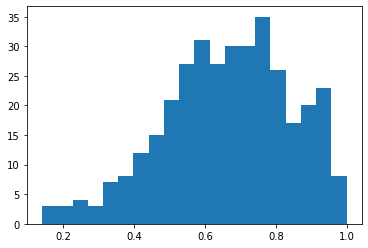

In [24]:
from Bio import SeqIO

epitope_dict = SeqIO.to_dict(SeqIO.parse("data/antigens_before_clustering.fasta", "fasta"))

all_true = []
all_pred = []

def tryfloat(x):
    try:
        x = float(x.split()[5])
        return x
    except:
        return -1000

performance_dict = dict()

metric = roc_auc_score

disco_glob = 'data/discotope_af2/*.txt' if SOLVED else 'data/discotope_solved/*.txt'

for filename in glob.glob(disco_glob):
    with open(os.path.join(os.getcwd(), filename), 'r') as f:
        pdb_id = os.path.splitext(filename)[0].rsplit("/", 1)[-1]
        reference_entry = epitope_dict.get(pdb_id, None)
        
        if reference_entry is None:
            raise ValueError('The reference for {} does not exist!'.format(pdb_id))

        reference = str(reference_entry.seq)
        reference_length = len(reference)
        
        y_true = [1 if reference[idx].isupper() else 0 for idx in range(reference_length) ]
        all_true.extend(y_true)
        
        lines = f.readlines()
        
        y_pred = [tryfloat(line) for line in lines[:reference_length]]
        all_pred.extend(y_pred)
        performance_dict[pdb_id] = metric(y_true, y_pred)

pdb_ids, performances = zip(*sorted(performance_dict.items()))

print("Micro-average:", metric(all_true, all_pred))

discotope_fpr, discotope_tpr, _ = roc_curve(all_true, all_pred)

plt.hist(performances, bins=20)
plt.show()

#print(pdb_ids)
#print(performances)



# BepiPred3
BepiPred3 is the, yet unpublished, state-of-the-art tool for predicting epitopes directly from sequence using ESM embedding instead of the structural embeddings we use in our methods. It uses a specific FFNN architecture, which we have tried to implement to the best of our ability to use with our dataset and compare.

In [25]:
embedding_dicts = list()

embedding_type = "data/esm_embeddings/"
SEQ_KEY_NAME = "seq_pdb"

for pt in glob.glob(embedding_type+'*.pt'):
    pt_obj = torch.load(pt)
    embedding_dicts.append(pt_obj)

fasta = {}
with open("data/antigens_before_clustering.fasta", "r") as file_one:
    for line in file_one:
        line = line.strip()
        if not line:
            continue
        if line.startswith(">"):
            active_sequence_name = line[1:]
            if active_sequence_name not in fasta:
                fasta[active_sequence_name] = []
            continue
        sequence = line
        fasta[active_sequence_name].append(sequence)

for embed_dict in embedding_dicts:
    embed_dict[SEQ_KEY_NAME] = fasta[embed_dict['label']][0]

In [26]:
def create_bepipred_datasets(list_of_dicts):
    n_seqs = len(list_of_dicts)
    seq_max_length = max([len(embed_dict[SEQ_KEY_NAME]) for embed_dict in list_of_dicts])
    embedding_dim = 1280

    with open("data/postapr2018_antigens.test.txt", "r") as infile:
        test_names = set([l.strip() for l in infile.readlines()])
    with open("data/preapr2018_antigens.train.txt", "r") as infile:
        train_names = set([l.strip() for l in infile.readlines()])
    with open("data/preapr2018_antigens.validation.txt", "r") as infile:
        val_names = set([l.strip() for l in infile.readlines()])

    X = torch.zeros(size=(n_seqs, seq_max_length, embedding_dim))
    y = torch.zeros(size=(n_seqs, seq_max_length))
    mask = torch.zeros(size=(n_seqs, seq_max_length))
    test_idx = list()
    train_idx = list()
    val_idx = list()
    for i, embed_dict in enumerate(list_of_dicts):
        seq = embed_dict[SEQ_KEY_NAME]
        pdb_id = embed_dict['label']
        embedding = list(embed_dict['representations'].values())[0]
        
        if pdb_id in test_names:
            test_idx.append(i)
        elif pdb_id in train_names:
            train_idx.append(i)
        elif pdb_id in val_names:
            val_idx.append(i)
        y_ = torch.Tensor([1 if letter.isupper() else 0 for letter in seq])

        X[i, 0:embedding.shape[0]] = embedding
        y[i, 0:len(y_)] = y_
        mask[i, 0:len(y_)] = torch.ones((1,len(y_)))

    test_idx = np.asarray(test_idx)
    train_idx = np.asarray(train_idx)
    val_idx = np.asarray(val_idx)


    random_indices = np.random.choice(len(train_idx), len(train_idx), replace=False)

    inputs_train = X[train_idx, :, :]
    inputs_test = X[test_idx, :, :]
    inputs_val = X[val_idx, :, :]
    targets_train = y[train_idx]
    targets_test = y[test_idx]
    targets_val = y[val_idx]
    masks_train = mask[train_idx]
    masks_test = mask[test_idx]
    masks_val = mask[val_idx]

    print("Training dims:", inputs_train.shape, targets_train.shape)
    print("Test dims:", inputs_test.shape, targets_test.shape)
    print("Validation dims:", inputs_val.shape, targets_val.shape)
    
    training_set = EpitopeDataset(inputs_train.to(device), targets_train.to(device), masks_train.to(device))
    validation_set = EpitopeDataset(inputs_val.to(device), targets_val.to(device), masks_val.to(device))
    test_set = EpitopeDataset(inputs_test.to(device), targets_test.to(device), masks_test.to(device))

    return training_set, validation_set, test_set

training_set, val_set, test_set = create_bepipred_datasets(embedding_dicts)

trainloader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE)

Training dims: torch.Size([216, 927, 1280]) torch.Size([216, 927])
Test dims: torch.Size([117, 927, 1280]) torch.Size([117, 927])
Validation dims: torch.Size([24, 927, 1280]) torch.Size([24, 927])


In [27]:
class BepiPred3Net(nn.Module):
    def __init__(self,
                 embedding_size = 1280,
                 fc1_size = 180,
                 fc2_size = 90,
                 fc3_size = 45,
                 fc1_dropout = 0.7,
                 fc2_dropout = 0.7,
                 fc3_dropout = 0.7,
                 num_of_classes = 1):
        super(BepiPred3Net, self).__init__()


        self.embedding_size = embedding_size
        self.fc1_size = fc1_size
        self.fc2_size = fc2_size
        self.fc3_size = fc3_size
        self.fc1_dropout = fc1_dropout
        self.fc2_dropout = fc2_dropout
        self.fc3_dropout = fc3_dropout

        self.ff_model = nn.Sequential(nn.Linear(embedding_size, fc1_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc1_dropout),
                                      nn.Linear(fc1_size, fc2_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc2_dropout),
                                      nn.Linear(fc2_size, fc3_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc3_dropout),
                                      nn.Linear(fc3_size, num_of_classes),
                                      nn.Sigmoid()
                                )
    def forward(self, x):
        output = x
        batch_size = output.size(0)
        seq_len = output.size(1)
        #convert dim (N, L, esm_embedding) --> (N*L, esm_embedding)
        output = torch.reshape(output, (batch_size*seq_len, self.embedding_size))
        output = self.ff_model(output)
        output = output.view(output.shape[0])
        return output

net = BepiPred3Net()
net.to(device)
print(net)

BepiPred3Net(
  (ff_model): Sequential(
    (0): Linear(in_features=1280, out_features=180, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.7, inplace=False)
    (3): Linear(in_features=180, out_features=90, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.7, inplace=False)
    (6): Linear(in_features=90, out_features=45, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.7, inplace=False)
    (9): Linear(in_features=45, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [28]:
BATCH_SIZE = 8
MAX_EPOCHS = 200
LR = 1e-4
LR_DECAY = 0.01

In [29]:
print("Starting training...")

train_X, train_y, train_mask = training_set[:]
test_X, test_y, test_mask = test_set[:]

criterion= nn.BCELoss(reduction='none')
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=LR_DECAY)

def weight_reset(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        m.reset_parameters()

net.apply(weight_reset)
losses=[]
training_plot=[]
test_plot=[]
auc_train_plot=[]
auc_test_plot=[]
mcc_train_plot=[]
mcc_test_plot=[]

last_score=np.inf
max_es_rounds = 5
es_rounds = max_es_rounds
best_epoch = 0

for epoch in range(MAX_EPOCHS):  # loop over the dataset multiple times
    net.train()
   
    for i, data in enumerate(trainloader,0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, mask = data
        inputs = inputs.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        #scheduler.step()     
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(torch.squeeze(outputs), torch.flatten(labels))
        mask = torch.flatten(mask)
        loss=loss*mask
        loss=torch.sum(loss)/torch.sum(mask)
   
        loss.backward()
        optimizer.step()
    
# print statistics
    with torch.no_grad():
        test_loss=0
        train_loss=0
        net.eval()
        inputs, labels, mask = training_set[:]

        outputs = net(inputs) 

        loss = criterion(torch.squeeze(outputs), torch.flatten(labels))
        labels = torch.flatten(labels)
        mask = torch.flatten(mask)
        loss=loss*mask
        loss=torch.sum(loss)/torch.sum(mask)
        training_plot.append(loss)
        auc_train_plot.append(roc_auc_score(labels.cpu()[mask.cpu()>0], outputs.cpu().squeeze()[mask.cpu()>0]))
        mcc_train_plot.append(mcc(labels.cpu()[mask.cpu()>0], outputs.cpu().squeeze()[mask.cpu()>0]>.1))
 

        inputs, labels, mask = test_set[:]
        outputs = net(inputs)
        loss = criterion(torch.squeeze(outputs), torch.flatten(labels))
        labels = torch.flatten(labels)
        mask = torch.flatten(mask)
        loss=loss*mask
        loss=torch.sum(loss)/torch.sum(mask)       
        test_plot.append(loss)
        fpr, tpr, _ = roc_curve(labels.cpu()[mask.cpu()>0], outputs.cpu()[mask.cpu()>0].squeeze())
        #labels, outputs= get_labels_preds_and_posprob_without_padding( outputs.flatten(),labels.flatten() )
        auc_test_plot.append(roc_auc_score(labels.cpu()[mask.cpu()>0], outputs.cpu()[mask.cpu()>0].squeeze()))
        mcc_test_plot.append(mcc(labels.cpu()[mask.cpu()>0], outputs.cpu().squeeze()[mask.cpu()>0]>.1))
        
        inputs, labels, mask = val_set[:]
        outputs = net(inputs)
        valloss = criterion(torch.squeeze(outputs), torch.flatten(labels))
        labels = torch.flatten(labels)
        mask = torch.flatten(mask)
        valloss=valloss*mask
        valloss=torch.sum(valloss)/torch.sum(mask)   
        
        print("Epoch {}, training loss {}, test loss {}, validation loss {}".format(epoch, training_plot[-1], test_plot[-1], valloss))
        print("Epoch {}, training AUC {}, test AUC {}".format(epoch, auc_train_plot[-1], auc_test_plot[-1]))
        print("Epoch {}, training MCC {}, test MCC {}".format(epoch, mcc_train_plot[-1], mcc_test_plot[-1]))

        
    if EARLY_STOPPING:
        if last_score > valloss:
            last_score = valloss
            best_epoch = epoch
            es_rounds = max_es_rounds
            best_model = copy.deepcopy(net)
            bepipred_fpr, bepipred_tpr = fpr, tpr
        else:
            if es_rounds > 0:
                es_rounds -=1
            else:
                print('EARLY-STOPPING !')
                print('Best epoch found: nº {}'.format(best_epoch))
                print('Exiting. . .')
                break

print("Finished training.")

Starting training...
Epoch 0, training loss 0.5777062773704529, test loss 0.5779709815979004, validation loss 0.5853484869003296
Epoch 0, training AUC 0.546848505861103, test AUC 0.5484896860185245
Epoch 0, training MCC 0.0, test MCC 0.0
Epoch 1, training loss 0.4381534457206726, test loss 0.43839186429977417, validation loss 0.45717450976371765
Epoch 1, training AUC 0.5556788297699491, test AUC 0.5495594112663905
Epoch 1, training MCC 0.0, test MCC 0.0
Epoch 2, training loss 0.30989718437194824, test loss 0.3101379871368408, validation loss 0.3496432602405548
Epoch 2, training AUC 0.5635021621178906, test AUC 0.5541257607334223
Epoch 2, training MCC 0.010867698647110827, test MCC 0.01564712467271822
Epoch 3, training loss 0.27949315309524536, test loss 0.27997705340385437, validation loss 0.3330826461315155
Epoch 3, training AUC 0.5819427965978329, test AUC 0.5687290470620641
Epoch 3, training MCC 0.06727022138437941, test MCC 0.05199049757672082
Epoch 4, training loss 0.2771047055721

Epoch 33, training loss 0.25058913230895996, test loss 0.26298394799232483, validation loss 0.3138059377670288
Epoch 33, training AUC 0.757660713465518, test AUC 0.6852973333861201
Epoch 33, training MCC 0.21862897779894433, test MCC 0.1464548365354383
Epoch 34, training loss 0.250057190656662, test loss 0.2627621591091156, validation loss 0.3136627972126007
Epoch 34, training AUC 0.7590364344759271, test AUC 0.6856903108387259
Epoch 34, training MCC 0.22121982054391576, test MCC 0.1460603580484993
Epoch 35, training loss 0.24950528144836426, test loss 0.26254603266716003, validation loss 0.31361669301986694
Epoch 35, training AUC 0.7608937677214, test AUC 0.6859293894780865
Epoch 35, training MCC 0.22197862004669613, test MCC 0.14666285995037603
Epoch 36, training loss 0.24906055629253387, test loss 0.262576162815094, validation loss 0.3128930628299713
Epoch 36, training AUC 0.7623135424697705, test AUC 0.685897031462042
Epoch 36, training MCC 0.22329582790302835, test MCC 0.147103472

Epoch 66, training loss 0.23909276723861694, test loss 0.26233556866645813, validation loss 0.3100992441177368
Epoch 66, training AUC 0.7917105742707689, test AUC 0.684560130460795
Epoch 66, training MCC 0.2562259089136638, test MCC 0.14718504747106256
Epoch 67, training loss 0.23887954652309418, test loss 0.2622758448123932, validation loss 0.3107263445854187
Epoch 67, training AUC 0.7921519266276733, test AUC 0.6844970194321589
Epoch 67, training MCC 0.2567629083302815, test MCC 0.14651747539184293
Epoch 68, training loss 0.23859204351902008, test loss 0.26234087347984314, validation loss 0.3105686902999878
Epoch 68, training AUC 0.7934393687359018, test AUC 0.6841093537766955
Epoch 68, training MCC 0.2594254515161586, test MCC 0.14520422397248747
Epoch 69, training loss 0.2383653074502945, test loss 0.26238498091697693, validation loss 0.3109295666217804
Epoch 69, training AUC 0.7941649092946014, test AUC 0.6840038821212092
Epoch 69, training MCC 0.26140363548727674, test MCC 0.1457

# Overall performance comparison
All five methods: our three own (FFN, RNN and GNN) and the two references (Discotope2 and BepiPred3) are compared in the ROC AUC plot below. Note that the GNN can only use AF2 structures in this notebook, BepiPred always uses sequence embeddings and the `SOLVED` flag can therefore only change the FFNN, RNN and the Discotope results.

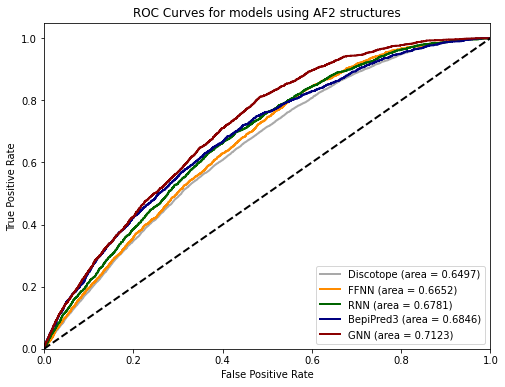

In [30]:
plt.figure(figsize=(8,6))
lw = 2
plt.plot(
    discotope_fpr,
    discotope_tpr,
    color="darkgrey",
    lw=lw,
    label="Discotope (area = %0.4f)" % auc(discotope_fpr, discotope_tpr),
)
plt.plot(
    ffnn_fpr,
    ffnn_tpr,
    color="darkorange",
    lw=lw,
    label="FFNN (area = %0.4f)" % auc(ffnn_fpr, ffnn_tpr),
)
plt.plot(
    rnn_fpr,
    rnn_tpr,
    color="darkgreen",
    lw=lw,
    label="RNN (area = %0.4f)" % auc(rnn_fpr, rnn_tpr),
)
plt.plot(
    bepipred_fpr,
    bepipred_tpr,
    color="navy",
    lw=lw,
    label="BepiPred3 (area = %0.4f)" % auc(bepipred_fpr, bepipred_tpr),
)
plt.plot(
    gnn_fpr,
    gnn_tpr,
    color="darkred",
    lw=lw,
    label="GNN (area = %0.4f)" % auc(gnn_fpr, gnn_tpr),
)
plt.plot([0, 1], [0, 1], color="black", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
structure_type = "solved" if SOLVED else "AF2"
plt.title("ROC Curves for models using {} structures".format(structure_type))
plt.legend(loc="lower right")
plt.show()